In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedShuffleSplit, GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from scipy.signal import savgol_filter
import plotly.express as px
import plotly.graph_objects as go
from icecream import ic

In [2]:
writer = pd.ExcelWriter("Ket qua phan loai khong dao ham.xlsx", engine='xlsxwriter')

In [3]:
data = pd.read_excel("../../data/Dataset_HPLC.xlsx", sheet_name="Vungtrong (140)")
data.head(10)

,No.,Name,Group,%CM,%CA,%CAL,600,602,604,606,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,1,21.1.8.YB-13,1,2.57,0.09,9.83,0.222,0.223,0.221,0.217,...,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006,-0.006
1,2,21.1.8.YB-24,1,0.69,0.04,3.75,0.263,0.261,0.257,0.257,...,-0.007,-0.007,-0.007,-0.007,-0.006,-0.007,-0.007,-0.007,-0.007,-0.007
2,3,21.1.8.YB-38,1,0.43,0.05,5.53,0.252,0.253,0.253,0.252,...,-0.006,-0.007,-0.007,-0.007,-0.006,-0.007,-0.007,-0.007,-0.007,-0.007
3,4,21.1.8.YB-40,1,2.04,0.06,5.21,0.259,0.258,0.259,0.259,...,-0.008,-0.009,-0.009,-0.009,-0.008,-0.008,-0.008,-0.009,-0.009,-0.009
4,5,21.1.8.YB-41,1,0.13,0.09,4.60,0.206,0.203,0.200,0.198,...,0.000,-0.001,0.000,0.001,0.001,0.000,0.000,-0.001,-0.001,-0.001
5,6,21.1.8.YB-42,1,1.02,0.08,4.37,0.246,0.245,0.246,0.245,...,-0.002,-0.002,-0.002,-0.001,-0.001,-0.001,-0.001,-0.002,-0.003,-0.003
6,7,21.1.8.YB-43,1,1.45,0.09,3.30,0.260,0.261,0.262,0.260,...,-0.004,-0.005,-0.005,-0.004,-0.003,-0.004,-0.004,-0.005,-0.005,-0.005
7,8,21.1.8.YB-44,1,1.65,0.06,4.01,0.248,0.248,0.248,0.247,...,-0.002,-0.003,-0.002,-0.001,-0.001,-0.001,-0.002,-0.003,-0.003,-0.003
8,9,21.1.8.YB-47,1,0.77,0.03,3.10,0.237,0.237,0.235,0.235,...,0.004,0.004,0.004,0.004,0.005,0.005,0.004,0.003,0.003,0.003
9,10,21.1.8.YB-48,1,1007.00,0.04,4.59,0.266,0.267,0.268,0.264,...,-0.001,-0.001,-0.001,0.000,0.000,0.000,-0.001,-0.001,-0.002,-0.002


In [4]:
y = data["Group"]
le = LabelEncoder()
y = le.fit_transform(y)
X = data.iloc[:, 6:]
X.columns = X.columns.astype(str)
cols = X.columns
print(np.unique(y))
print(le.inverse_transform(np.unique(y)))

[0 1 2 3]
[1 2 3 4]


In [5]:
X = pd.DataFrame(X, columns=cols)

In [6]:
X.shape

(139, 1701)

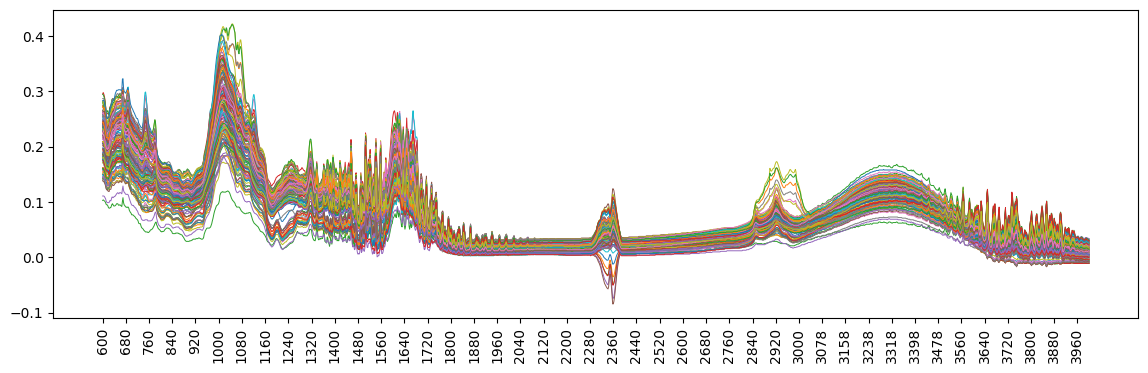

In [7]:
plt.figure(figsize=(14, 4))
plt.plot(X.T, linewidth= 0.7)
plt.xticks(X.columns[::40], rotation=90)
plt.show()

In [8]:
X = savgol_filter(X, window_length=25, polyorder=3, deriv=1)

### Train test split

In [9]:
X = np.array(X)  # In case it's not already a NumPy array
y = np.array(y)

n_classes = len(np.unique(y))
# Define how many samples per class you want in the validation set
n_test_samples_per_class = int(len(X) * 0.25 / n_classes)  # Modify this based on your need

# Get unique class labels
classes = np.unique(y)
# Lists to hold train and test data
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# For each class, split data to have equal test size
for cls in classes:
    # Get indices for this class
    class_indices = np.where(y == cls)[0]
    
    # Split the data for this class
    X_class, X_class_test, y_class, y_class_test = train_test_split(
        X[class_indices], y[class_indices], test_size=n_test_samples_per_class, random_state=42
    )
    
    # Append the splits to the train/test lists
    X_train_list.append(X_class)
    X_test_list.append(X_class_test)
    y_train_list.append(y_class)
    y_test_list.append(y_class_test)

# Combine back into arrays
X_train = np.vstack(X_train_list)  # Combine all classes' training data
X_test = np.vstack(X_test_list)      # Combine all classes' test data
y_train = np.hstack(y_train_list)  # Combine all classes' training labels
y_test = np.hstack(y_test_list)      # Combine all classes' test labels

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_test.shape, y_test.shape)

Training set shape: (107, 1701) (107,)
Validation set shape: (32, 1701) (32,)


In [10]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(random_state=42)
# Fit the model to generate the data.
X_train, y_train = sm.fit_resample(X_train, y_train)

In [11]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [12]:
np.random.seed(0)
res = {}

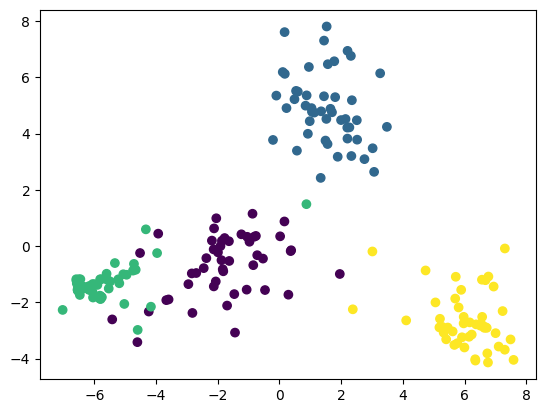

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

pca = PCA(40)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

lda = LinearDiscriminantAnalysis(n_components=3)
X_train_lda = lda.fit_transform(X_train_pca, y_train)
X_test_lda = lda.transform(X_test_pca)

plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c = y_train)
plt.scatter(X_test_lda[:, 0], X_test_lda[:, 1], c = y_test)
plt.show()

In [14]:
import plotly.graph_objects as go
import numpy as np

x1 = X_train_lda[:, 0]
y1 = X_train_lda[:, 1]
z1 = X_train_lda[:, 2]

x2 = X_test_lda[:, 0]
y2 = X_test_lda[:, 1]
z2 = X_test_lda[:, 2]


# Create a 3D scatter plot
fig = go.Figure()
# Add the first scatter trace
fig.add_trace(go.Scatter3d(
    x=x1,
    y=y1,
    z=z1,
    mode='markers',
    marker=dict(
        size=5,
        color=y_train,  # Color for the first set
        opacity=0.8
    ),
    # hovertemplate = hover_text_re,
))

# Add the second scatter trace
fig.add_trace(go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        size=5,
        color=y_test,  # Color for the second set
        opacity=0.8
    ),
    # hovertemplate = hover_text_than,
))

# Set the layout of the plot
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    width = 800,
    height = 600,
    title='Multiple 3D Scatter Plots Example'
)

# Show the plot
fig.show()

In [15]:
from sklearn.metrics import accuracy_score

y_pred = lda.predict(X_test_pca)
lda_accuracy = accuracy_score(y_test, y_pred)

In [16]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train_lda, y_train)
y_pred = svm.predict(X_test_lda)
lda_svm_accuracy = accuracy_score(y_test, y_pred)


PCA-SVC

ic| grid.best_params_: {'pca__n_components': 35, 'svc__kernel': 'linear'}




Accuracy score: 0.96875


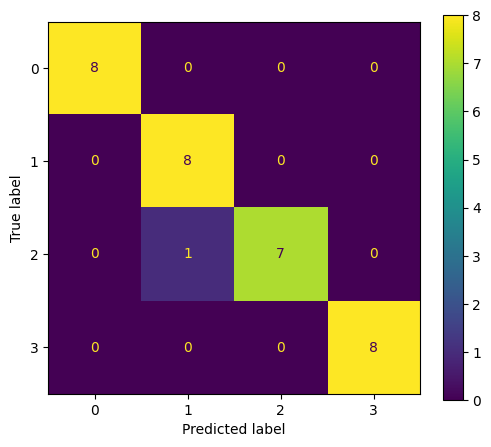

In [17]:
pca = PCA()
svc = SVC()
pipeline = Pipeline(steps=[('pca', pca), ('svc', svc)])
param_grid = {
    'pca__n_components': np.arange(1,42),
    'svc__kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-GaussNB

ic| grid.best_params_: {'pca__n_components': 18}




Accuracy score: 0.84375


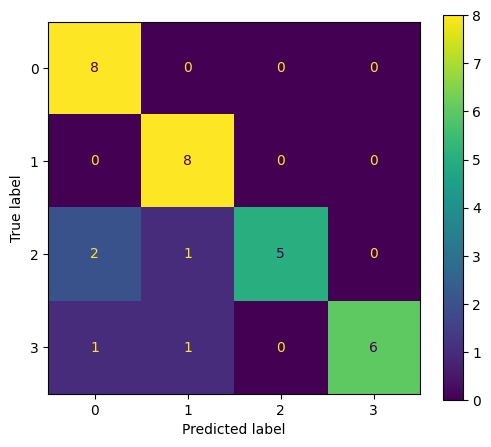

In [18]:
pca = PCA()
gauss_nb = GaussianNB()
pipeline = Pipeline(steps=[('pca', pca), ('gauss', gauss_nb)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm =confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-BernouliNB

ic| grid.best_params_: {'pca__n_components': 7}




Accuracy score: 0.8125


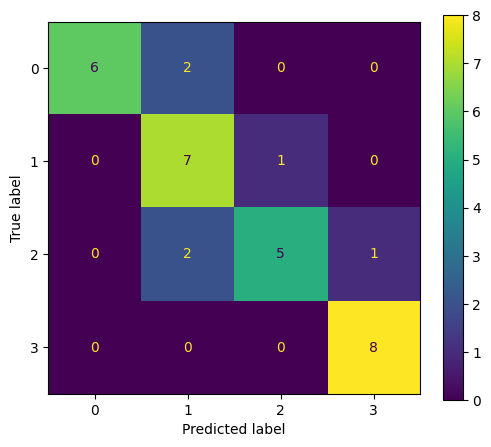

In [19]:
pca = PCA()
ber_nb = BernoulliNB()
pipeline = Pipeline(steps=[('pca', pca), ('ber', ber_nb)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm =confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-RF

ic| grid.best_params_: {'pca__n_components': 29}




Accuracy score: 0.9375


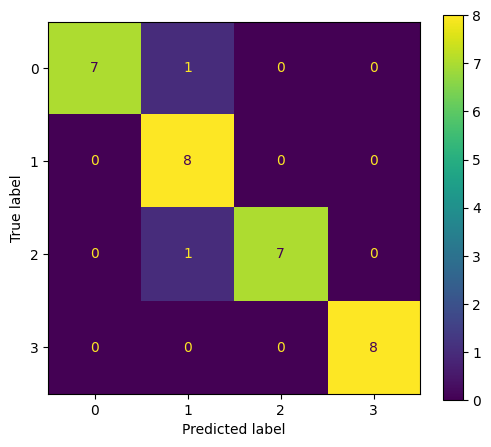

In [20]:
pca = PCA()
rf = RandomForestClassifier()
pipeline = Pipeline(steps=[('pca', pca), ('rf', rf)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm =confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-DT

ic| grid.best_params_: {'pca__n_components': 8}




Accuracy score: 0.71875


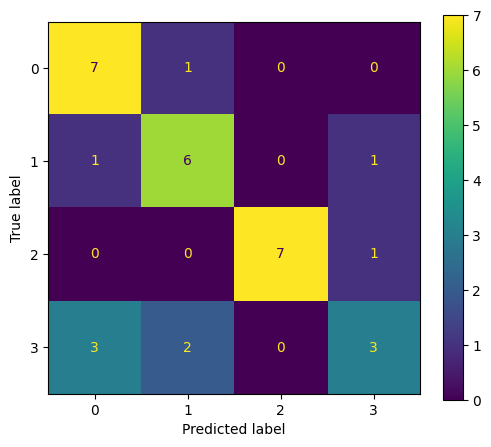

In [21]:
pca = PCA()
dt = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('pca', pca), ('dt', dt)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm =confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-AdaBoost

ic| grid.best_params_: {'pca__n_components': 36}




Accuracy score: 0.875


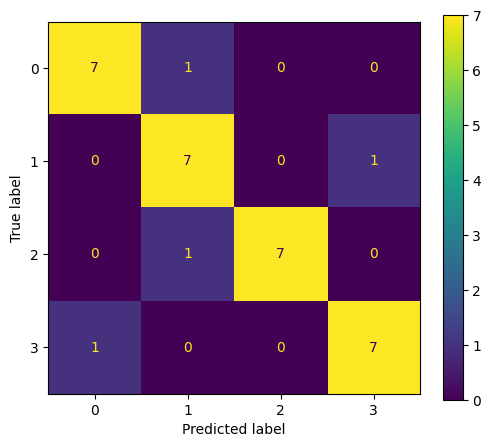

In [22]:
pca = PCA()
ada = AdaBoostClassifier()
pipeline = Pipeline(steps=[('pca', pca), ('ada', ada)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

PCA-GradientBoost

ic| grid.best_params_: {'pca__n_components': 40}




Accuracy score: 0.90625


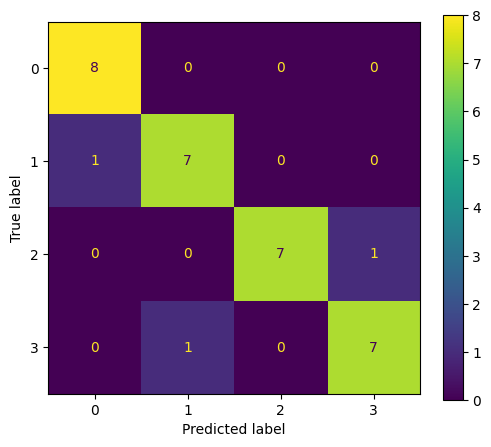

In [23]:
pca = PCA()
grad_boost = GradientBoostingClassifier()
pipeline = Pipeline(steps=[('pca', pca), ('grad_boost', grad_boost)])
param_grid = {
    'pca__n_components': np.arange(1,42),
}  

grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 0) 
grid.fit(X_train, y_train) 
print("\n")
ic(grid.best_params_) 
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy score:",accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,5))
cmd.plot(ax=ax)
plt.show()
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
model_name = ""
for step in pipeline.get_params()['steps']:
    model_name = model_name + str(type(step[1]).__name__) + "-"
model_name = model_name[:-1]
report.T.to_excel(writer, sheet_name=model_name, index=False)
res[model_name] = accuracy_score(y_test, y_pred)

In [24]:
res["LDA"] = lda_accuracy
res["LDA_SVM"] = lda_svm_accuracy

In [25]:
writer.close()

In [26]:
res

{'PCA-SVC': 0.96875,
 'PCA-GaussianNB': 0.84375,
 'PCA-BernoulliNB': 0.8125,
 'PCA-RandomForestClassifier': 0.9375,
 'PCA-DecisionTreeClassifier': 0.71875,
 'PCA-AdaBoostClassifier': 0.875,
 'PCA-GradientBoostingClassifier': 0.90625,
 'LDA': 0.96875,
 'LDA_SVM': 0.875}